## Objective

- To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms.
- To provide recommendations to the bank on how to better market to and service these customers.

## Data

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing Libraries

In [1]:
import numpy as np   
from sklearn.linear_model import LinearRegression
import pandas as pd    
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import zscore
# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)
# to scale the data using z-score
from sklearn.preprocessing import StandardScaler
# to compute distances
from scipy.spatial.distance import pdist
# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
# to perform PCA
from sklearn.decomposition import PCA
# to compute distances
from scipy.spatial.distance import cdist
# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

### Read Dataset

In [2]:
data = pd.read_excel("Credit Card Customer Data.xlsx")

### Shape of Dataset

In [3]:
print(f"There are {data.shape[0]} rows and {data.shape[1]} columns.")  # f-string

There are 660 rows and 7 columns.


### View Dataset

In [4]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [5]:
data.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


### Create Copy

In [6]:
df = data.copy()

### Checking Datatype

In [7]:
# checking datatypes and number of non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


### Duplication Check

In [8]:
df[df.duplicated()].count()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Missing Value Check

In [9]:
df.isnull().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

### Dropping unecessary columns

In [10]:
df.drop(['Sl_No', 'Customer Key'],axis=1,inplace=True)

- Primary key is the same as the index and is not statistically relvant

### Dataset Summary

In [11]:
df.median()

Avg_Credit_Limit       18000.0
Total_Credit_Cards         5.0
Total_visits_bank          2.0
Total_visits_online        2.0
Total_calls_made           3.0
dtype: float64

In [12]:
# Let's look at the statistical summary of the data
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


## EDA

### Univariate Analysis

In [13]:
def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

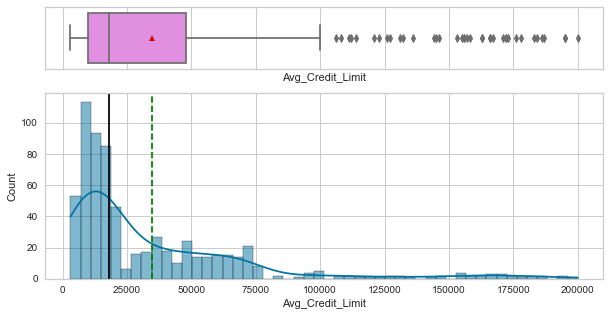

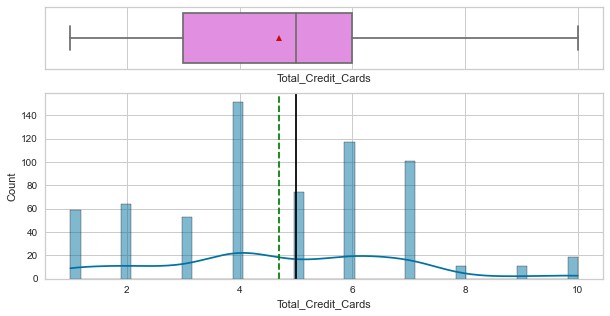

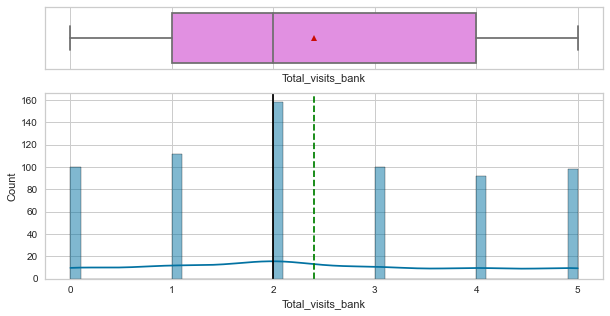

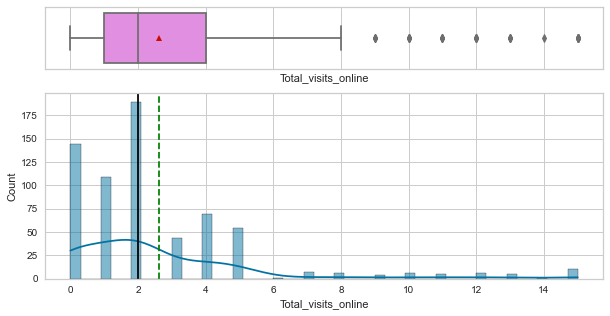

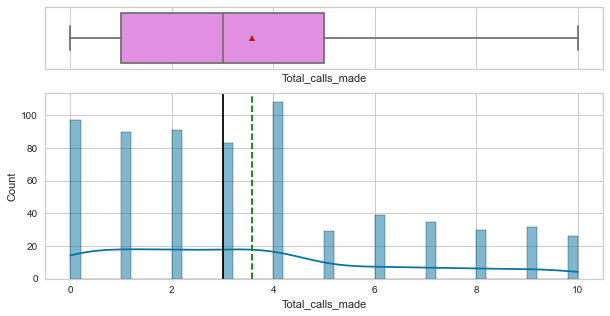

In [14]:
for col in df.columns:
    histogram_boxplot(df, col, bins=50, kde=True, figsize=(10, 5))

#### Observations

- Avg_Credit_Limit, Total_visits_bank, Total_visits_online are right skewed
- Total_Credit_Card and Total_call_made are left skewed
- Total_Cred_card, Total_visits_bank and Total_calls made have no outliers
- 75% of customers have an average credit limit under 48000, 6 or less credit cards, make 4 or less visits to the bank, make 4 or less visits online and have 5 or less total calls made

## Bivariate Analysis

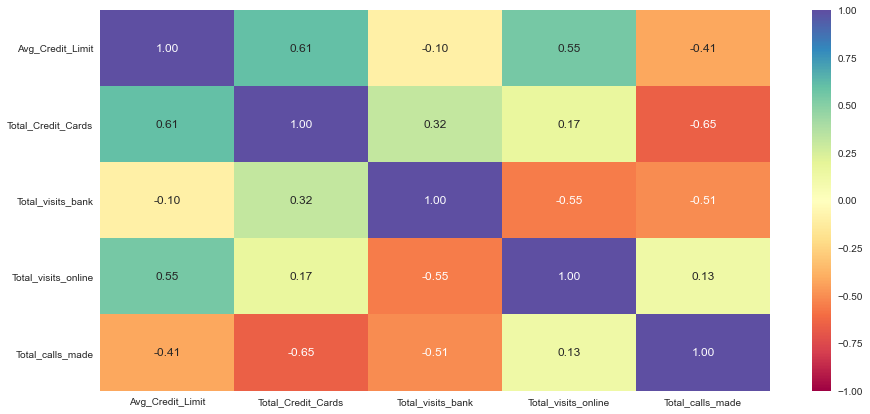

In [15]:
plt.figure(figsize=(15, 7))
sns.heatmap(
    df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

- Avg_Credit_Limit positively correlated with total_Credit_Cards and _Total_visits_Online, negatively correlated with Total_calls_made and Total_visits_bank
- Total_Credit_Cards positively correlated with Total_visits_bank and Total_visits_online, negatively correlated with Total_calls_made
- Total_visits_bank negatively correlated with Total_visits_online and Total_calls_made

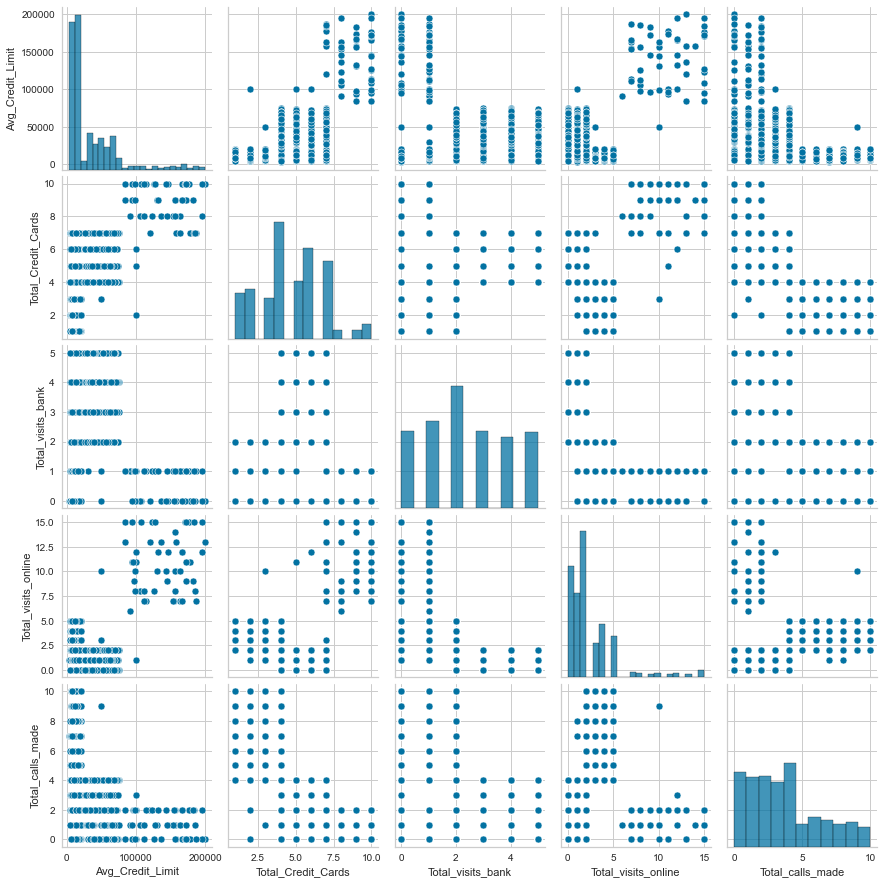

In [16]:
sns.pairplot(data=df)
plt.show()

### Summary of EDA
**Data Description**:
* No Duplicate values
* No missing values
* few of outliers
* All datatypes are **int64***


**Data Cleaning:**
* No Duplicates
* Dropped ID Columns


**Observations from EDA**
* `Avg_Credit_Limit`: 
    * Right Skewed
    * Avg_Credit_Limit positively correlated with total_Credit_Cards and _Total_visits_Online, negatively correlated with Total_calls_made and Total_visits_bank
    * 75% of customers have an average credit limit under 48000
    
* `Total_Credit_Cards`: 
    * Left Skewed
    * Total_Credit_Cards positively correlated with Total_visits_bank and Total_visits_online, negatively correlated with Total_calls_made
    * No outliers
    * 75% of customers have 6 or less credit cards

    
* `Total_visits_bank`: 
    * Right Skewed
    * Total_visits_bank negatively correlated with Total_visits_online and Total_calls_made
    * 75% of customers make 4 or less visits to the bank

* `Total_visits_online`:     
    * Right Skewed
    * No outliers
    * 75% of customers make 4 or less visits online
    
* `Total_calls_made`: 
    * Left Skewed
    * No outliers
    * 75% of customers have 5 or less total calls made

### Scaling Data

In [17]:
sc = StandardScaler()
subset_scaled_df = pd.DataFrame(
    sc.fit_transform(df),
    columns=df.columns,
)
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


### K-Means Clustering

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.990772333470802
Number of Clusters: 6 	Average Distortion: 0.9430843103448057
Number of Clusters: 7 	Average Distortion: 0.9093991915419353
Number of Clusters: 8 	Average Distortion: 0.891012634861478
Number of Clusters: 9 	Average Distortion: 0.8632891600598763
Number of Clusters: 10 	Average Distortion: 0.8467102794285297
Number of Clusters: 11 	Average Distortion: 0.8162750011362481
Number of Clusters: 12 	Average Distortion: 0.8055302333585189
Number of Clusters: 13 	Average Distortion: 0.7814599036839671
Number of Clusters: 14 	Average Distortion: 0.7710193137983241
Number of Clusters: 15 	Average Distortion: 0.7506052151334701


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

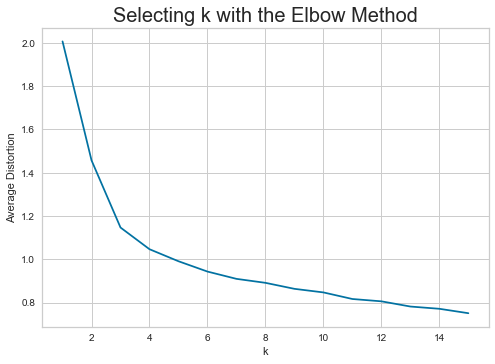

In [18]:
clusters = range(1, 16)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)
    distortion = (
        sum(
            np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1)
        )
        / subset_scaled_df.shape[0]
    )

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)

### Visualizing to ensure optimal elbow curve

C:\Users\User\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


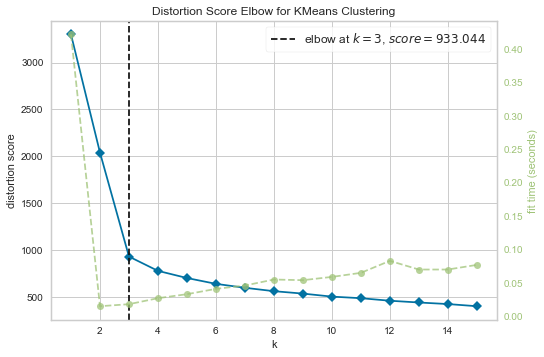

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(1,16), timings= True)
visualizer.fit(subset_scaled_df)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

- Elbow method suggests the optimal value of K is 3

For n_clusters = 2, silhouette score is 0.41842496663215445
For n_clusters = 3, silhouette score is 0.5157182558881063
For n_clusters = 4, silhouette score is 0.3556670619372605
For n_clusters = 5, silhouette score is 0.2717470361089752
For n_clusters = 6, silhouette score is 0.255499043345148
For n_clusters = 7, silhouette score is 0.248175083050816
For n_clusters = 8, silhouette score is 0.22708508639891067
For n_clusters = 9, silhouette score is 0.21908157754347024
For n_clusters = 10, silhouette score is 0.2116407026520288
For n_clusters = 11, silhouette score is 0.20986105743821806
For n_clusters = 12, silhouette score is 0.2099878706509714
For n_clusters = 13, silhouette score is 0.21400881666552216
For n_clusters = 14, silhouette score is 0.2198456586277497
For n_clusters = 15, silhouette score is 0.20885534851270507


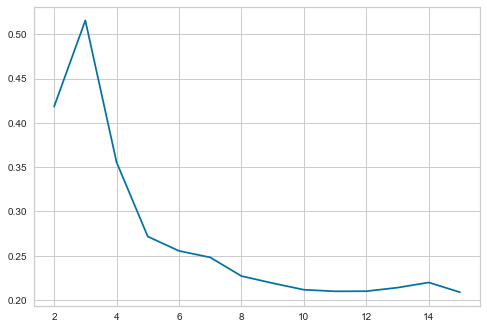

In [20]:
sil_score = []
cluster_list = list(range(2, 16))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)


### Visualizing to ensure optimal silhouette

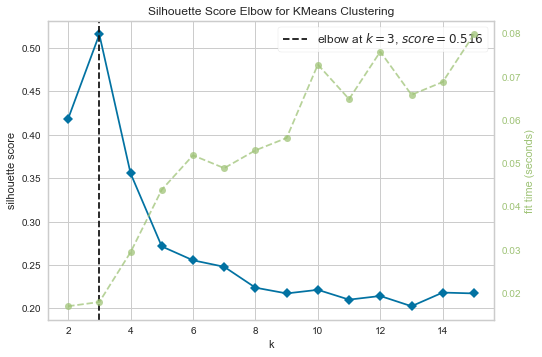

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
model = KMeans()
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,16),metric='silhouette', timings= True)
visualizer.fit(subset_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

- Sihouette score also suggests that 3 is the optimal dumber of clusters

### Buidling K-Means model

In [22]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=1)

In [23]:
df_k = df.copy()

In [24]:
# adding kmeans cluster labels to the original dataframe
df_k["K_means_segments"] = kmeans.labels_

### Cluster Profile

In [25]:
cluster_profile = df_k.groupby("K_means_segments").mean()

In [26]:
cluster_profile["count_in_each_segment"] = (
    df_k.groupby("K_means_segments")["Avg_Credit_Limit"].count().values
)

In [27]:
# let's display cluster profiles
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


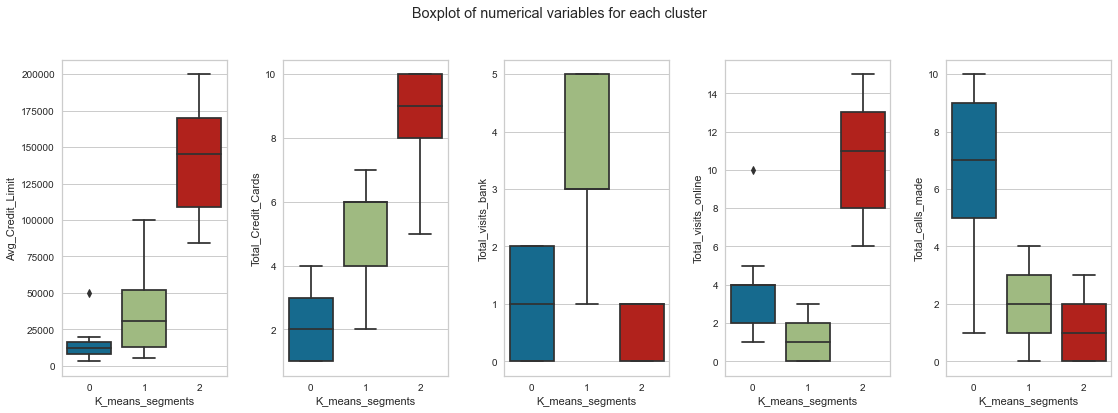

In [28]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_k[num_col[counter]], x=df_k["K_means_segments"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

### Insights

* <b>Cluster 0</b>
    * Avg_Credit_Limit range low to very low
    * Total_Credit_Cards range is very low to moderate
    * Total_visits_bank range is very low to moderate
    * Total_visits_online range is low to moderate
    * Total_calls_made range is low to high
* <b>Cluster 1</b>
    * Avg_Credit_Limit range is very low to moderate
    * Total_Credit_Cards range is low to moderate
    * Total_visits_bank range is low to high
    * Total_visits_online range is low to very low
    * Total_calls_made range is very low to moderate
* <b>Cluster 2</b>
    * Avg_Credit_Limit range is moderate to very high
    * Total_Credit_Cards range is moderate to very high
    * Total_visits_bank range is very low to low
    * Total_visits_online range is moderate to very high
    * Total_calls_made range is very low to low

## Hierarchichal Clustering

In [29]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553606.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875361.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

In [30]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


- Highest Determined linkage was with Euclidian distance, now w'll explore linkages more specifically

In [31]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


In [32]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


- Highest cophenetic correlation is with average linkage

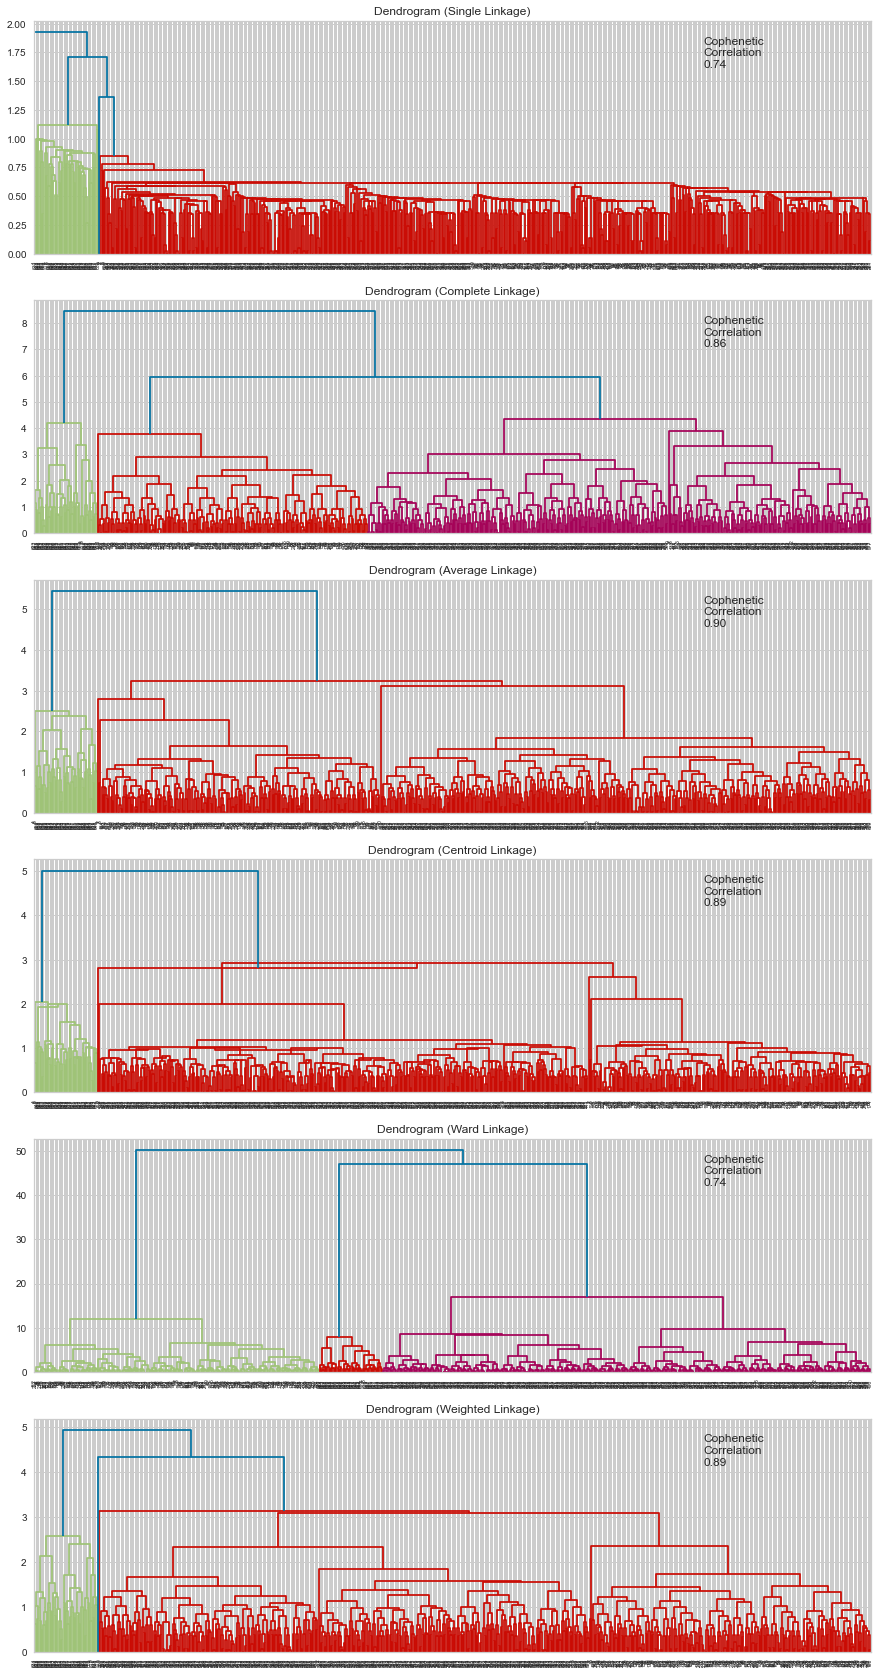

In [33]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

### Observations
    - The cophenetic correlation is highest for average linkage
    - We will move ahead with Average linkage
    - Appropriate number of clusters from dendogram is 3

#### Silhouette score

For n_clusters = 2, silhouette score is 0.5324323437846029
For n_clusters = 3, silhouette score is 0.590990473596407
For n_clusters = 4, silhouette score is 0.51800640075783
For n_clusters = 5, silhouette score is 0.4668481242339674
For n_clusters = 6, silhouette score is 0.44083418432752164
For n_clusters = 7, silhouette score is 0.44385695631157895
For n_clusters = 8, silhouette score is 0.3855318376449286
For n_clusters = 9, silhouette score is 0.3840134273512098
For n_clusters = 10, silhouette score is 0.38797420527600024
For n_clusters = 11, silhouette score is 0.25086738319086993
For n_clusters = 12, silhouette score is 0.24979092796780913
For n_clusters = 13, silhouette score is 0.2190884622116411
For n_clusters = 14, silhouette score is 0.19684047746308864
For n_clusters = 15, silhouette score is 0.19517841126875102


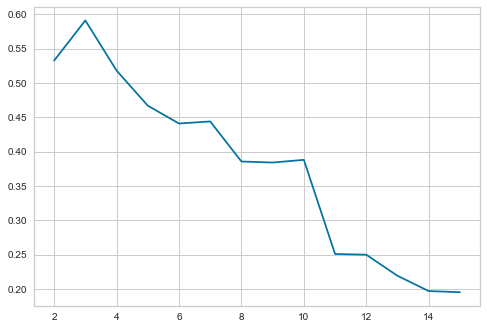

In [45]:
sil_score = []
cluster_list = list(range(2, 16))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity="euclidean", linkage="average")
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))

plt.plot(cluster_list, sil_score)


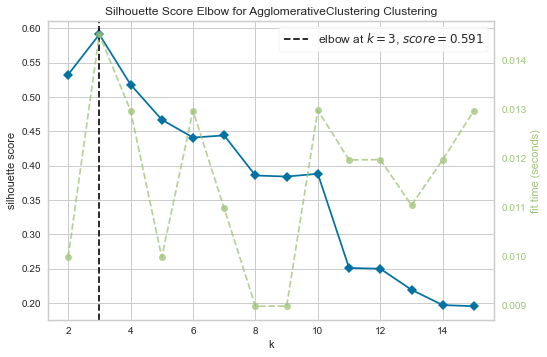

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [46]:
model = AgglomerativeClustering(affinity="euclidean", linkage="average")
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,16),metric='silhouette', timings= True)
visualizer.fit(subset_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Creating Hierarchical Clustering Model

In [47]:
HCmodel = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="average")
HCmodel.fit(subset_scaled_df)

AgglomerativeClustering(linkage='average', n_clusters=3)

In [48]:
subset_scaled_df["HC_Clusters"] = HCmodel.labels_
df["HC_Clusters"] = HCmodel.labels_

### Cluster profile

In [49]:
cluster_profile2 = df.groupby("HC_Clusters").mean()

In [50]:
cluster_profile2["count_in_each_segments"] = (
    df.groupby("HC_Clusters")["Avg_Credit_Limit"].count().values
)

In [51]:
# lets display cluster profile
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


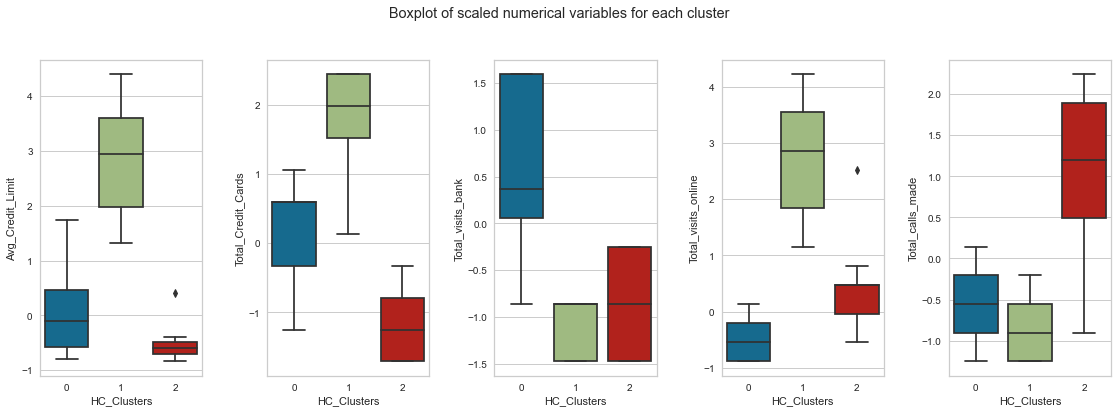

In [52]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of scaled numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=subset_scaled_df[num_col[counter]], x=subset_scaled_df["HC_Clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0)

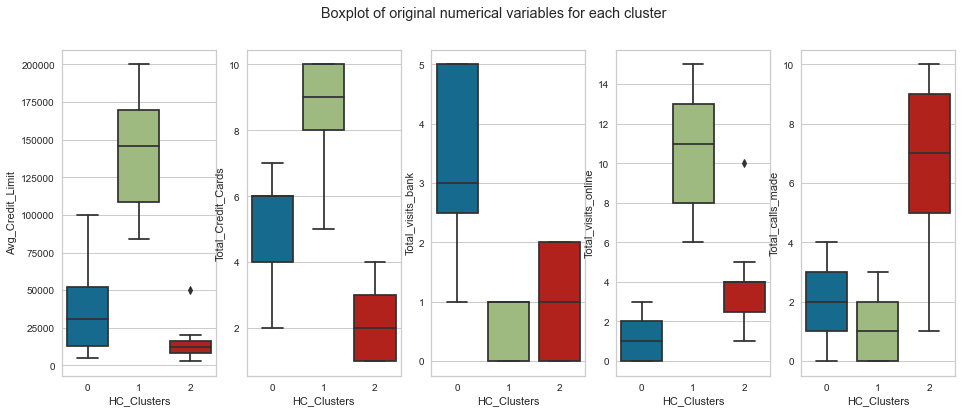

In [53]:
num_col = df.select_dtypes(include=np.number).columns.tolist()
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle("Boxplot of original numerical variables for each cluster")
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df[num_col[counter]], x=df["HC_Clusters"])
    counter = counter + 1


### Insights

* <b>Cluster 0</b>
    * Avg_Credit_Limit range is very low to moderate
    * Total_Credit_Cards range is low to moderate
    * Total_visits_bank range is low to very high
    * Total_visits_online range is very low to low
    * Total_calls_made range is very low to low
* <b>Cluster 1</b>
    * Avg_Credit_Limit range is moderate to very high
    * Total_Credit_Cards range is moderate to very high
    * Total_visits_bank range is very low to low
    * Total_visits_online range is moderate to high
    * Total_calls_made range is very low to low
* <b>Cluster 2</b>
    * Avg_Credit_Limit range is very low
    * Total_Credit_Cards range is very low to low
    * Total_visits_bank range is very low to low
    * Total_visits_online range is low
    * Total_calls_made range is low to high


## Comparing K-means and Hierarchical clustering

In [54]:
cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,12174.107143,2.410714,0.933036,3.553571,6.870536,224
1,33782.383420,5.515544,3.489637,0.981865,2.000000,386
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


In [55]:
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
HC_Clusters,,,,,,
0,33713.178295,5.511628,3.485788,0.984496,2.005168,387
1,141040.000000,8.740000,0.600000,10.900000,1.080000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,223


### Observations
- Computing dendograms took much longer and so Hierarchal clustering is much more intensive and time consuming
- Appropriate number of clusters vary are the same, both suggesting 3 clusters
- Clusters 2 from K-means and 3 from Hierarchical have the same amount of observations, wheras the rest share similar amounts of observations with only 1 observation difference.
- For Hierarchichal the silhouette score at 3 clusters is 0.590990473596407, wheras for K-means the silhouette score at 3 clusters is 0.5157182558881063
- We will use Hierarchichal clustering for insights as it has a higher silhouette score

### Business Insights
* <b>Cluster 0</b>
    * There are 387 customers in this cluster
    * The average credit card limit is very low to moderate and total calls made by the customer is very low to low
    * This cluster rarely uses the bank's online portal and has a low to high number of inperson bank visits
    * This cluster has a low to moderate amount of credit cards
* <b>Cluster 1</b>
    * There are 50 customers in this cluster
    * The average credit card limit is very moderate to very high and total calls made by the customer is very low to low
    * This cluster rarely visits the bank in person and uses the online portal moderately to often/very high.
    * This cluster has a moderate to very high amount of credit cards
* <b>Cluster 2</b>
    * There are 223 customers in this cluster
    * The average credit card limit is very low and total calls made by the customer is low to high
    * This cluster rarely visits the bank in person and rarely uses the online portal (both low)
    * This cluster has a very low to low amount of credit cards

### Recommendations
* In-person advertisements such as those on bank signs and given by bank tellers would be likely to reach cluster 0.]
* Advertisement campaigns on the bank site would most likely reach cluster 1.
    * Better service would affect cluster 1 the least.
    * Small cluster size suggested there is very little market penetration in this cluster currently.
* Targeted phone campaigns would most likely reach cluster 2.
    * Better service would affect cluster 2 the most.
    * Since this cluster has low total credit cards and less Credit limit offering packages that increase limit with new    cards may be prefferable.
        